In [1]:
# Genetic Algorithm - Graph Colouring Problem
# Project for Evolutionary Algorithms class at VUT FIT Brno
# Date: March 2023
# Author: Bc. Sebastian Krajnak
# Genetic operations, chromosone representation based on:
# Genetic Algorithm Applied to the Graph Coloring Problem (Musa M Hindi, Roman Yampolskiy)
# Some functions used were either copied or edited from EVO Lab 2 code by Ing. Martin Hurta

import numpy as np
import matplotlib.pyplot as plt
import random
from math import ceil
import csv
import os

In [8]:
# BIN extension----------------------------------------------------------------------
# Generate graph
# graph will be represented by an adjacency matrix where 1's mean the vertices are connected
# the graph is unordered so it is symmetrical and has 0s on the main diagonal
def generate_graph(n):
  print("Generating adjacency matrix...")
  num_vertices = n
  graph = [[0] * num_vertices for _ in range(num_vertices)]
  num_edges = 0
  
  # (num_vertices*(num_vertices-1)/2 * 0.30) use for 30%, with 60 for 531, with 25 for90
  # (num_vertices*(num_vertices-1)/2 * 0.85) use for 85%, with 60 for 1504, with 25
  # (num_vertices**2)/4* 1.05/6 use with 120 for 630 aka 10% connected
  while(num_edges != int( (num_vertices**2)/4*1.05/6 )):
      vertex1, vertex2 = random.sample(range(num_vertices),2)
      if(graph[vertex1][vertex2] != 1):
        graph[vertex1][vertex2] = 1
        graph[vertex2][vertex1] = 1
        num_edges += 1

  print(f"done! Graph has {num_vertices} vertices and {num_edges} edges")

  return graph, num_edges, num_vertices

def compute_upper_bound(current_upper=float('inf')):
  initial_upper = np.max(np.diag(np.sum(np.array(graph), axis =1) )) # Maximum degree in the graph
  if current_upper == float('inf'):
    return initial_upper
  elif current_upper <= initial_upper:
    return current_upper - 1

graph, num_edges, num_vertices = generate_graph(120)
chromatic_number = compute_upper_bound()
print(f"Chromatic number upper bound is {chromatic_number}")

#Helper function from github to check if generated graph is symmetric
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
print(f"Is graph symmetrical ? {check_symmetric(np.array(graph))}")

Generating adjacency matrix...
done! Graph has 120 vertices and 630 edges
Chromatic number upper bound is 18
Is graph symmetrical ? True


In [ ]:
# Load graphs from .col files -------------------------------------------------------
def parse_file(filename):
    print(f"Creating a graph from file {filename}")
    with open(filename, 'r') as f:
        # Skip lines until we reach the line starting with 'p edge'
        line = f.readline().strip()
        while not line.startswith('p edge'):
            line = f.readline().strip()

        # Get the number of vertices from the 'p edge' line
        num_vertices = int(line.split()[2])
        num_edges = int(line.split()[3])

        # Create an empty adjacency matrix
        adjacency_matrix = [[0] * num_vertices for _ in range(num_vertices)]

        # Parse the edges and update the adjacency matrix
        for line in f:
            if line.startswith('e'):
                _, v1, v2 = line.split()
                v1, v2 = int(v1) - 1, int(v2) - 1  # Convert to 0-indexed
                adjacency_matrix[v1][v2] = 1
                adjacency_matrix[v2][v1] = 1  # Assuming undirected graph
        print(f"...done! Graph has {num_vertices} vertices and {int(num_edges/2)} edges.")
        return adjacency_matrix, num_vertices

graph_files = [ # list of tuples where (graph_file, known_chromatic_number)
    ("graphs/miles250.col", 8),
    ("graphs/miles1000.col", 42),
    ("graphs/queen5_5.col", 5),
    ("graphs/games120.col", 9),
    ]
graph, num_vertices = parse_file(graph_files[1][0])
chromatic_number = graph_files[1][1]

Creating a graph from file graphs/miles1000.col
...done! Graph has 128 vertices and 3216 edges.


In [4]:
# Variables to tweak with -----------------------------------------------------------
# all variables used for the evolution are easily found on one place here
num_runs = 30

num_generations = 4000
population_size = 130
mutation_probability = 0.236012
crossover_probability = 0.876543
all_fitness = np.array([])

csv_name = "fitness.csv"

In [5]:
# Genetical operators ---------------------------------------------------------------
def tournament_selection(population, scores, k=2): # Author: Ing. Martin Hurta

    # Getting random ordering of individuals
    random_order = list(range(0, len(population)))
    np.random.shuffle(random_order)

    # Selecting the first individual to start with
    best_idx = random_order[0]

    # Tournament selection with the remaining individuals and saving the individual with the lowest fitness
    for i in range(1, k):

        if scores[random_order[i]] < scores[best_idx]:
            best_idx = random_order[i]

    return population[best_idx]

def fitness(solution): # Penalty for every vertex connecting 2 nodes with the same color
    fitness = 0
    for i in range(num_vertices):
        for j in range(i, num_vertices):
            if(solution[i] == solution[j] and graph[i][j] == 1):
                fitness += 1
    return fitness

def single_point_crossover(p1, p2, crossover_probability): # Author: Ing. Martin Hurta

    # Children initialization
    c1, c2 = p1.copy(), p2.copy()

    # Checking if crossover will happen
    if np.random.uniform() < crossover_probability:

        # Selecting a non-finite point for crossover
        pt = np.random.randint(1, len(p1)-2)

        # Crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]

# Helper function for mutations, finds all colours adjecent to given vertex
def find_adjecent_colors(vertex, chromosone):
  adj_vertices = graph[vertex]
  adj_colors = [chromosone[i] for i in range(len(chromosone)) if adj_vertices[i] == 1]

  return adj_colors

# Mutation function used when fitness > 4
def mutation_high_fit(chromosone, mutation_probability, chromatic_num):
  all_colors = [i for i in range(chromatic_num)]
  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)
    if chromosone[vertex] in adj_colors:
      valid_colors = [all_colors[i] for i in range(chromatic_num) if all_colors[i] not in adj_colors]

      if(valid_colors): # If list is empty choose random color
        new_color = random.choice(valid_colors)
      else:
        new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

# Mutation function when fitness value is <= 4
def mutation_low_fit(chromosone, mutation_probability, chromatic_num):
  all_colors = list(range(chromatic_num))

  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)
    if chromosone[vertex] in adj_colors:
      new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

# Mutation function used when fitness is not making progress for a set amount of generations
def mutation_problem_individuals(chromosone, mutation_probability, chromatic_num):
  all_colors = list(range(chromatic_num))
  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)

    for j in range(vertex, num_vertices):
      if(chromosone[vertex] == chromosone[j] and graph[vertex][j] == 1):
        valid_colors = [all_colors[i] for i in range(chromatic_num) if all_colors[i] not in adj_colors]

        if(valid_colors): # If list is empty choose random color
          new_color = random.choice(valid_colors)
        else:
          new_color = random.choice(all_colors)
        chromosone[vertex] = new_color

In [ ]:
# Genetic algorithm EVO ----------------------------------------------------------------------
# Author of the original algorithm Ing. Martin Hurta with editions by me
def genetic_algorithm(num_generations, population_size, crossover_probability, chromatic_num, mutation_probability, all_fitness):
  # Random initial population inicialization
  population = [np.random.randint(0, chromatic_num-1, num_vertices).tolist() for _ in range(population_size)]

  # Inicialization of the best initial individuals
  best_individual = 0
  best_eval = fitness(population[0])
  new_best = -1
  best_history = []

  # Evolution
  gen = 0
  no_progress_counter = 0

  while(gen != num_generations and best_eval != 0):
    # Fitness score evaluation in canditate population
    scores = [fitness(indivitual) for indivitual in population]

    # Get best solution in population
    for i in range(population_size):
      if scores[i] < best_eval:
        best_individual = population[i]
        best_eval = scores[i]
        with open(csv_name, 'a') as csvfile:
          csvwriter = csv.writer(csvfile)
          csvwriter.writerow([gen, best_eval, chromatic_num])
        new_best = i

    # Display information about new best solution
    if new_best != -1:
      print(">%d, new best f(%s) = %d, chromatic number = " % (gen,  population[new_best], scores[new_best]), chromatic_num)
      best_history.append([gen, scores[new_best]])
      new_best = -1
    else:
      no_progress_counter += 1

    # Parents selection in the size of the whole population
    selected = [tournament_selection(population, scores) for _ in range(population_size)]
    all_fitness = np.append(all_fitness, best_eval)
    next_gen_parents = selected[:int(population_size/2)]
    population = next_gen_parents

    # Creating the next generation
    for i in range(0, int(population_size/2), 2):
      # Parent selection for crossover
      p1, p2 = selected[i], selected[i+1]

      # Probability dependent crossover
      for c in single_point_crossover(p1, p2, crossover_probability):
        # Mutation of individuals
        if best_eval > 4:
          mutation_high_fit(c, mutation_probability,chromatic_num)
        else:
          mutation_low_fit(c, mutation_probability,chromatic_num)

        if no_progress_counter >= int(num_generations/6):
          mutation_problem_individuals(c, mutation_probability, chromatic_num)
          print(f"Mutating problem individuals, no progress in {no_progress_counter} generations...")
          no_progress_counter = 0

        # Appending children to the next generation
        population.append(c)

    gen += 1
    if(gen == num_generations):
      print(f"Max number of generations reached ! Stopping evolution...")

  return [best_individual, best_eval, best_history, all_fitness]


In [6]:
# Genetic algorithm BIN ----------------------------------------------------------------------
# Author of the original algorithm Ing. Martin Hurta with editions by me
def genetic_algorithm(num_generations, population_size, crossover_probability, chromatic_num, mutation_probability, all_fitness):
  condition = True
  chromatic_history = [] # BIN addition
  successful_chromatic = [] #BIN addition
  best_history = []

  while condition and chromatic_num > 0:
    best_history_indiv_number = []
    # Random initial population inicialization
    population = [np.random.randint(0, chromatic_num-1, num_vertices).tolist() for _ in range(population_size)]

    # Inicialization of the best initial individuals
    best_individual = 0
    best_eval = fitness(population[0])
    new_best = -1

    # Evolution
    gen = 0
    no_progress_counter = 0

    while(gen != num_generations and best_eval != 0):
      # Fitness score evaluation in canditate population
      scores = [fitness(indivitual) for indivitual in population]

      # Get best solution in population
      for i in range(population_size):
        if scores[i] < best_eval:
          best_individual = population[i]
          best_eval = scores[i]
          with open(csv_name, 'a') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([gen, best_eval, chromatic_num])
          new_best = i

      # Display information about new best solution
      if new_best != -1:
        print(">%d, new best f(%s) = %d, chromatic number = " % (gen,  population[new_best], scores[new_best]), chromatic_num)
        best_history_indiv_number.append([gen, scores[new_best]])
        chromatic_history.append(chromatic_num)
        new_best = -1
      else:
        no_progress_counter += 1

      # Parents selection in the size of the whole population
      selected = [tournament_selection(population, scores) for _ in range(population_size)]
      all_fitness = np.append(all_fitness, best_eval)
      next_gen_parents = selected[:int(population_size/2)]
      population = next_gen_parents


      # Creating the next generation
      for i in range(0, int(population_size/2), 2):
        # Parent selection for crossover
        p1, p2 = selected[i], selected[i+1]

        # Probability dependent crossover
        for c in single_point_crossover(p1, p2, crossover_probability):

          # Mutation of individuals
          if best_eval > 4:
            mutation_high_fit(c, mutation_probability,chromatic_num)
          else:
            mutation_low_fit(c, mutation_probability,chromatic_num)

          if no_progress_counter >= int(num_generations/6):
            mutation_problem_individuals(c, mutation_probability, chromatic_num)
            print(f"Mutating problem individuals, no progress in {no_progress_counter} generations...")
            no_progress_counter = 0

          # Appending children to the next generation
          population.append(c)

      gen += 1
      if(gen == num_generations):
        print(f"Max number of generations reached ! Stopping evolution...")
        condition = False
    if best_eval == 0:
      successful_chromatic = chromatic_num
    best_history.append(best_history_indiv_number)
    chromatic_num -= 1

  return [best_individual, best_eval, best_history, all_fitness, chromatic_history, successful_chromatic]

Ideas to plot
1. y= fitness x= different values for mut_prob BOXPLOT
2. y= fitness x= different values for pop_size BOXPLOT => bigger pop needs lower num of runs pocet evaluaci sa musi rovnat ( GEN_SIZE * POP_SIZE)
3. median, max, min, q2, q4 NOT as a boxplot but as a konvergencni krivka EVO lecture 9

grafy stacia maly (queen6_6.col), velky(queen8_8.col), s malym (miles250.col) a velkym(miles1000.col) prepojenim
prezentacia je len jedna pre BIN a EVO



In [ ]:
# Running and result plotting EVO ------------------------------------------------------------
# Prepare csv file for fitness data
fields = ["Generation", "Fitness_value", "Chromatic_number"]
with open(csv_name, 'w') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(fields)

# Execution of genetic algorithm
results = [genetic_algorithm(num_generations, population_size, crossover_probability,chromatic_number, mutation_probability, all_fitness) for _ in range(num_runs)]

# Get total success rate of all runs
num_successes = sum([1 for result in results if result[1] == 0])
success_rate = num_successes/num_runs

# Get average fitness for all runs
# This is absolutely dumb way to sum it all but I need it fast for the pojednani
fit_sum = 0
len_fit = 0
for i in range(num_runs):
  fit_sum += np.sum(results[i][3])
  len_fit+= len(results[i][3])
avg_fitness = fit_sum/len_fit

print(f'Done! Total success rate is {success_rate*100} % with average fitness {avg_fitness}.')

# Plot the course of the fitness function for each run
figure, ax = plt.subplots(figsize=(10, 5))
for i in range(len(results)):
    ax.plot(*zip(*results[i][2]) )
ax.grid()
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness value')
ax.set_xscale('log') # better to have log scale for generations axis   due to slow descent in the beginning
plt.title('Best fitness score of generations for all runs')
plt.tight_layout()
plt.show()

>0, new best f([8, 9, 10, 16, 2, 12, 11, 6, 1, 10, 10, 13, 10, 6, 12, 9, 3, 5, 5, 13, 10, 13, 5, 2, 14, 3, 8, 8, 0, 16, 0, 7, 0, 5, 4, 11, 12, 4, 5, 3, 7, 8, 3, 10, 0, 6, 11, 15, 8, 4, 13, 16, 11, 10, 10, 13, 13, 7, 11, 1, 11, 6, 6, 3, 9, 10, 2, 1, 15, 11, 10, 13, 4, 8, 1, 1, 4, 4, 11, 2, 1, 16, 1, 7, 11, 16, 3, 7, 8, 4, 6, 9, 9, 6, 3, 9, 15, 5, 7, 10, 0, 12, 0, 4, 14, 12, 16, 9, 6, 13, 12, 12, 6, 10, 15, 2, 2, 16, 0, 7]) = 25, chromatic number =  18
>1, new best f([12, 0, 11, 6, 10, 11, 9, 13, 7, 9, 16, 1, 1, 7, 7, 6, 14, 14, 15, 10, 13, 7, 13, 1, 10, 3, 8, 9, 4, 10, 1, 4, 2, 15, 8, 5, 17, 12, 11, 14, 12, 0, 15, 11, 6, 1, 6, 0, 5, 8, 10, 2, 14, 13, 10, 7, 4, 10, 0, 15, 3, 7, 11, 4, 17, 2, 2, 12, 13, 1, 4, 17, 13, 10, 8, 5, 15, 0, 5, 11, 10, 2, 4, 16, 2, 15, 14, 5, 4, 12, 1, 9, 6, 13, 7, 9, 13, 14, 11, 3, 7, 2, 2, 10, 4, 3, 12, 15, 5, 13, 3, 9, 9, 13, 0, 1, 7, 13, 6, 15]) = 11, chromatic number =  18
>2, new best f([12, 0, 11, 6, 10, 11, 9, 13, 5, 9, 16, 16, 1, 7, 7, 10, 14, 11, 12, 10

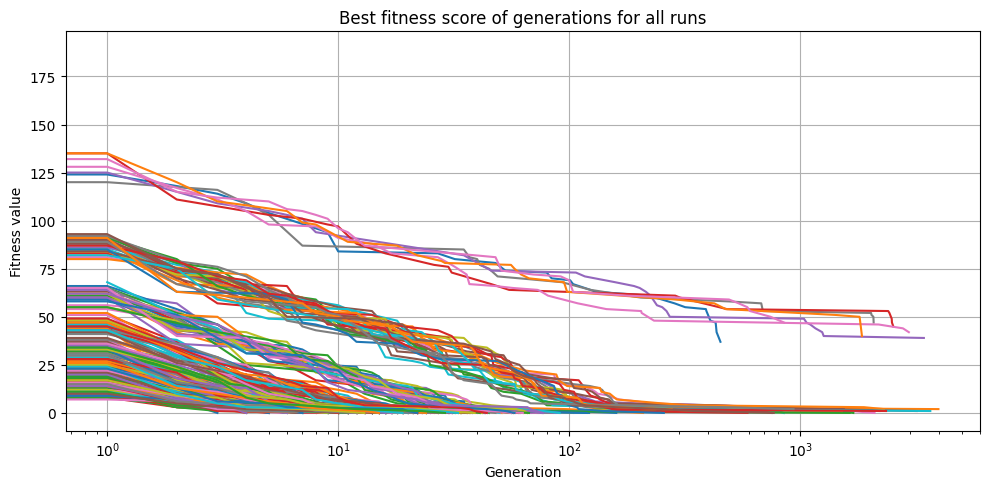

In [9]:
# Running and result plotting BIN ------------------------------------------------------------
# Prepare csv file for fitness data
fields = ["Generation", "Fitness_value", "Chromatic_number"]
with open(csv_name, 'w') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(fields)

# Execution of genetic algorithm
results = [genetic_algorithm(num_generations, population_size, crossover_probability, chromatic_number, mutation_probability, all_fitness) for _ in range(num_runs)]

# Get total success rate of all runs
num_successes = sum([1 for result in results if result[1] == 0])
success_rate = num_successes/num_runs

# Get average fitness for all runs
# This is absolutely dumb way to sum it all but I need it fast for the pojednani
# UPDATE this code heresy is staying because of time crunch
fit_sum = 0
len_fit = 0
chroma_history = []
chroma_succesful = []
for i in range(num_runs):
  fit_sum += np.sum(results[i][3])
  len_fit+= len(results[i][3])
  chroma_history.append(results[i][4]) # BIN ONLY
  chroma_succesful.append(results[i][5]) # BIN ONLY

# BIN ONLY
avg_fitness = fit_sum/len_fit 
best_chromatic = np.reshape(np.array(chroma_succesful), len(chroma_succesful))
best_chromatic = np.min(best_chromatic[np.nonzero(best_chromatic)])



print(f'Done! Average fitness was {avg_fitness} and smallest found chromatic number {best_chromatic}')

# Plot the course of the fitness function for each run
figure, ax = plt.subplots(figsize=(10, 5))
''' for i in range(len(results)):
    ax.plot(*zip(*results[i][2]) ) '''
for i in range(len(results)):
  for item in results[i][2]:
    ax.plot(*zip(*item) )
ax.grid()
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness value')
ax.set_xscale('log') # better to have log scale for generations axis   due to slow descent in the beginning
plt.title('Best fitness score of generations for all runs')
plt.tight_layout()
plt.show()

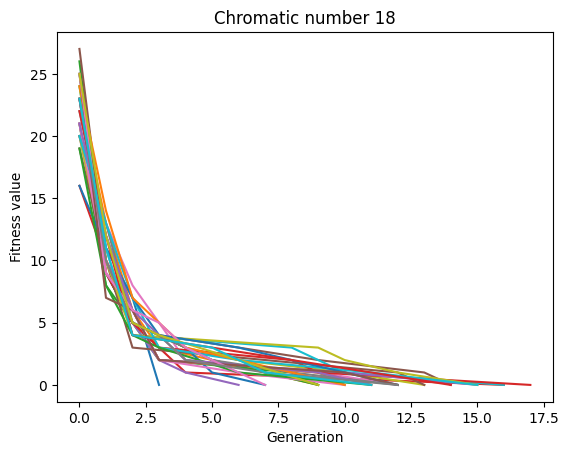

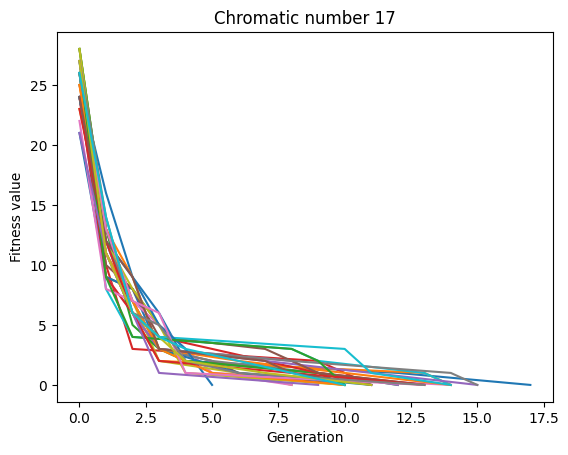

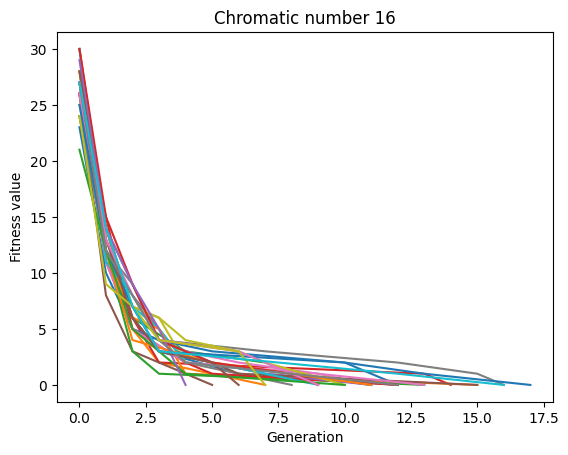

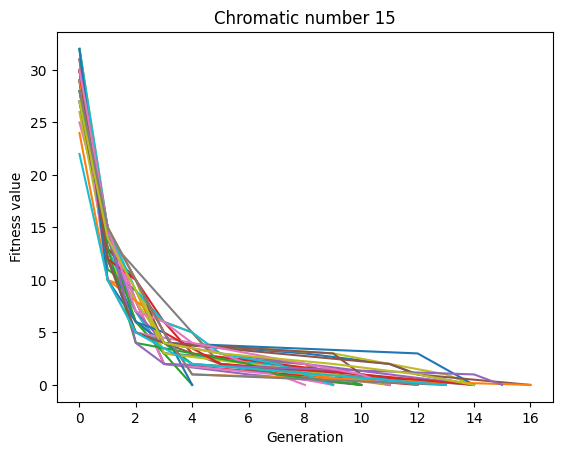

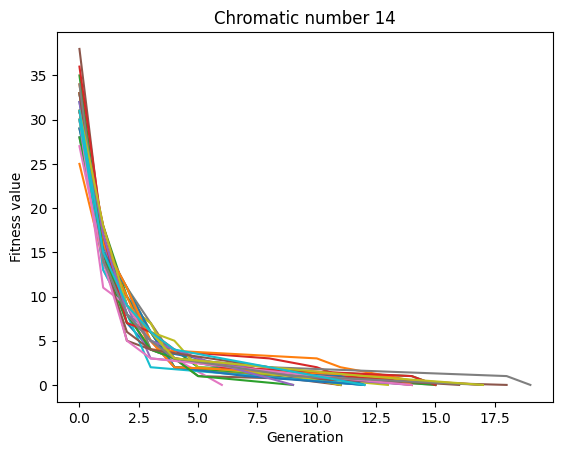

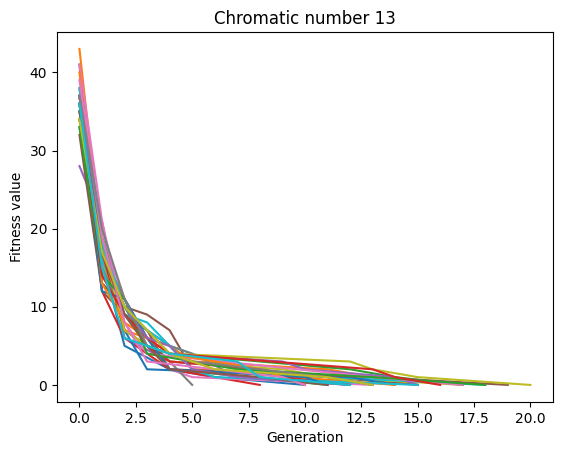

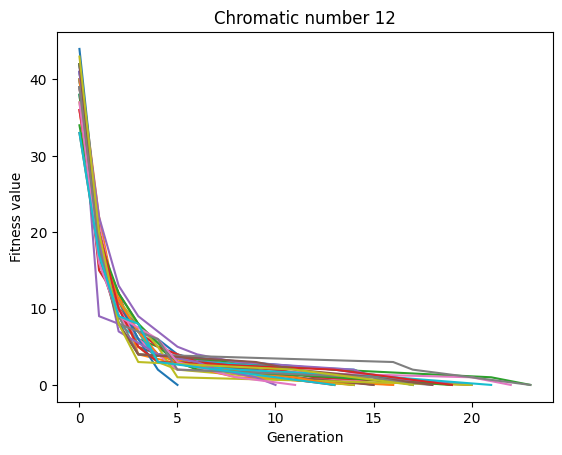

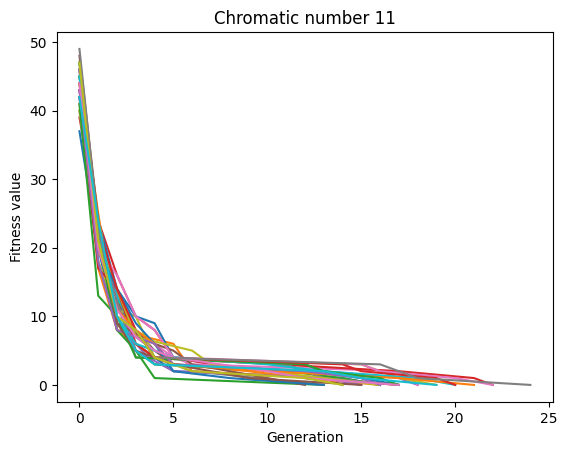

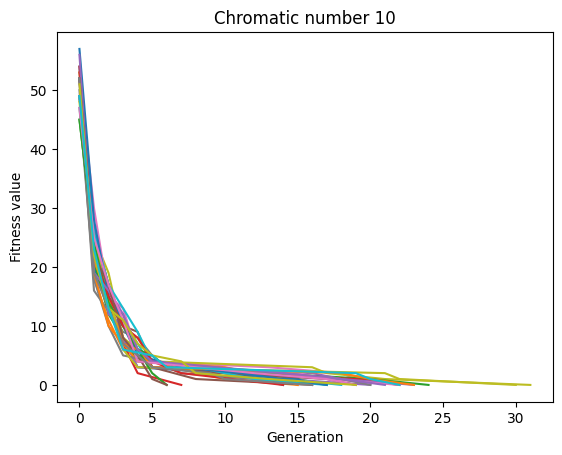

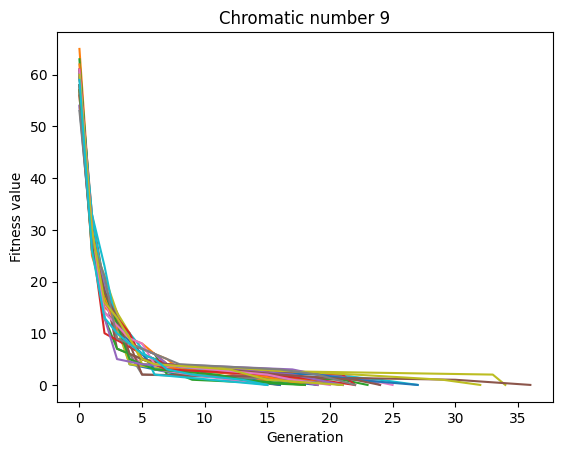

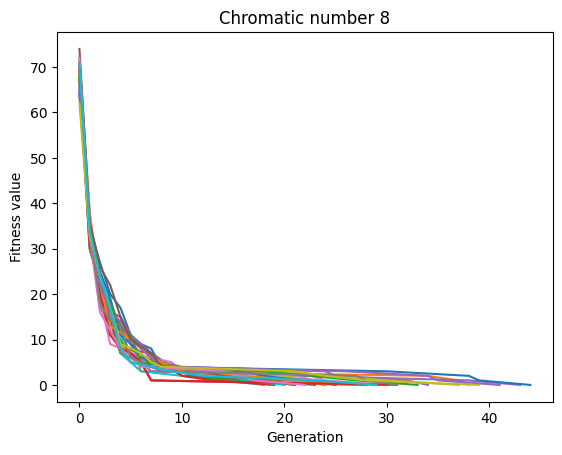

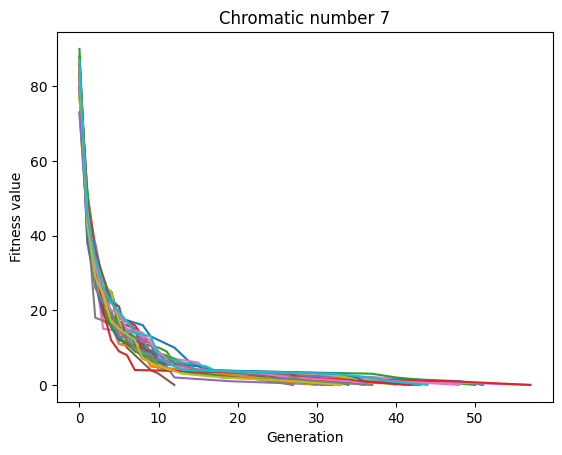

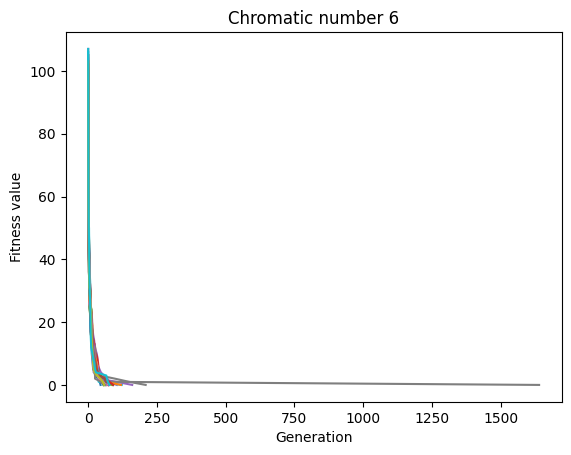

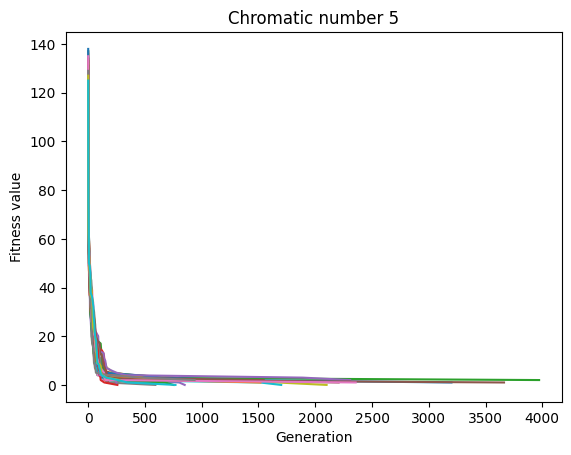

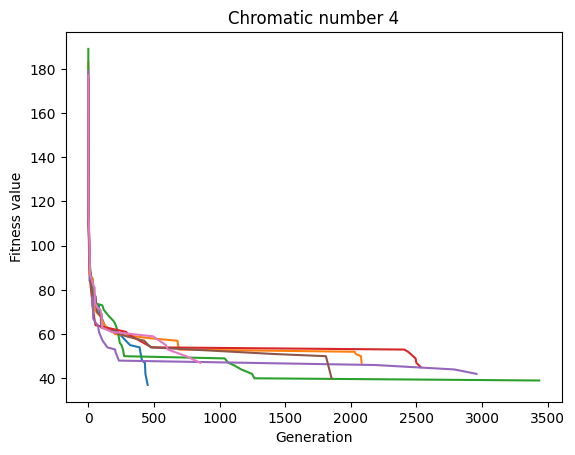

In [10]:
# BIN plot evolution of fitness value for each chromatic number
max_chroma = max(len(run[2]) for run in results)

for i in range(max_chroma):
  plt.figure()
  for run in results:
    if i < len(run[2]):
      x, y = zip(*run[2][i])
      plt.plot(x, y)
      #plt.plot(run[2][i])
      plt.xlabel('Generation')
      plt.ylabel('Fitness value')
      plt.title('Chromatic number ' + str(chromatic_number-i))

  plt.savefig(os.path.join('chroma_graphs', 'chromatic_number_' + str(chromatic_number-i) + '.png'))
  plt.show()


[[ 0  5]
 [ 1  1]
 [ 5  7]
 ...
 [11  0]
 [ 0  5]
 [ 1  0]]


Text(0.5, 1.0, 'Konvergencni krivka')

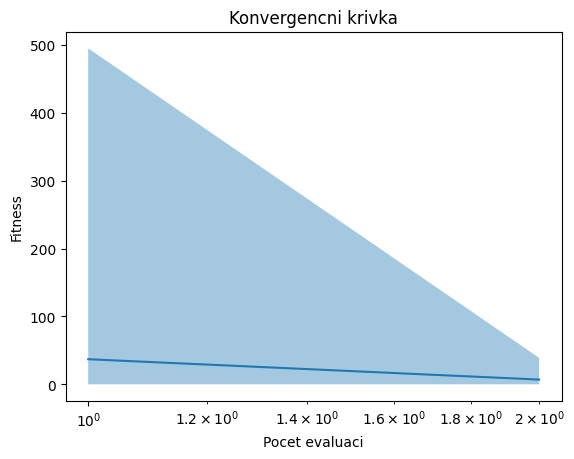

In [ ]:
best_history_lists = [result[2] for result in results]
xy = np.concatenate(best_history_lists)

mins = np.min(xy, axis=0)
meds = np.median(xy, axis=0)
maxs = np.max(xy, axis=0)
print(xy)
xy.shape
plt.xscale('log')
x = np.arange(1,2+1)
plt.plot(x,meds)
plt.fill_between(x,mins,maxs,alpha=0.4)
plt.xlabel('Pocet evaluaci')
plt.ylabel('Fitness')
plt.title('Konvergencni krivka')
